<a href="https://colab.research.google.com/github/praful055/FossFinal/blob/main/FOSS_Final_Praful.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Libraries and Requirements
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import random
from nltk import tokenize
from operator import itemgetter
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install geopandas
!pip install descartes
import geopandas as gpd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 972kB 9.5MB/s 
     |████████████████████████████████| 6.5MB 23.4MB/s 
     |████████████████████████████████| 14.8MB 229kB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#Transformation Functions for Pre-Processing
def transform1(ls):
    ls1 = []
    for i in ls:
        if i[0]!="event_id":
            if i[0]=='nan' and i[1]=='nan':# Skiping blank lines from the sheet
                continue
            else:
                ls1.append(i)
    ls2 = transform2(ls1) # send list to combine signal and disconnect rows
    return ls2

def transform2(ls1):
    i=0
    ls2 = []
    while i < len(ls1):
        if ls1[i][0]!='nan':
            nw = ls1[i]
            i+=2 # skip the title row (signal,disconnect)
            signal = []
            disconnect = []
            while ls1[i][0]=='nan': # appending all signal and disconnect data as list and appending to 
                signal.append(ls1[i][1])
                disconnect.append(ls1[i][2])
                i+=1
                if(i==len(ls1)): #safety net
                    break
            nw.append(signal)
            nw.append(disconnect)
            ls2.append(nw) #Appending df to combined list
        else:
            i+=1    
    return ls2 #one list with all data and corresponding signal time and disconnect cause as list of list

In [3]:
combined = []
for i in range(1,4):
  df1 = pd.read_excel("/content/drive/MyDrive/Foss/Crime Prediction.xlsx", header=0,sheet_name=str(i))
  df = df1.iloc[:,0:16]
  df = df.replace(np.nan,'nan', regex=True)
  ls = df.values.tolist()
  ls1 = transform1(ls)
  for item in ls1:
    combined.append(item)
print("No. of Entries after cleaning data: ",len(combined))

No. of Entries after cleaning data:  801


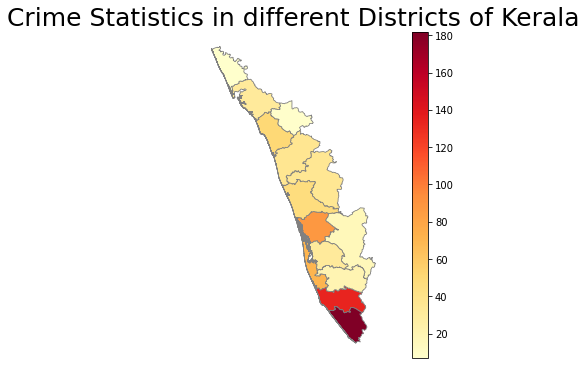

In [4]:
  count = {}
  for i in combined:
    if i[4] not in count:
      count[i[4]] = 1
    else:
      count[i[4]] +=1
  ls = []
  for i in count.keys():
    if(i=="nan"):
      continue
    temp = []
    temp.append(i)
    temp.append(count[i])
    ls.append(temp)
  district_wise=pd.DataFrame(ls)
  fp = "/content/drive/MyDrive/Foss/gadm36_IND_shp/gadm36_IND_2.shp"
  map_df = gpd.read_file(fp)
  map_df = map_df[['NAME_1', 'NAME_2', 'geometry']]
  map_df = map_df[map_df['NAME_1']=='Kerala']
  merged = map_df.set_index('NAME_2').join(district_wise.set_index(0))
  merged[1].fillna(0, inplace=True)
  fig, ax = plt.subplots(1, figsize=(10, 6))
  ax.axis('off')
  ax.set_title('Crime Statistics in different Districts of Kerala', fontdict={'fontsize': '25', 'fontweight' : '3'})
  # plot the figure
  merged.plot(column=1, cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.5',legend=True)

In [5]:
def parse_time(text):
  sep = '.'
  stripped = text.split(sep, 1)[0]
  return stripped

def convert_time(date_time1,date_time2):
  string1 = parse_time(date_time1)
  string2 = parse_time(date_time2)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  datetime_str2 = datetime.datetime.strptime(string2, format)
  time = str(datetime_str2 - datetime_str1)
  return sum(x * int(t) for x, t in zip([60, 1, 1/60], time.split(":")))

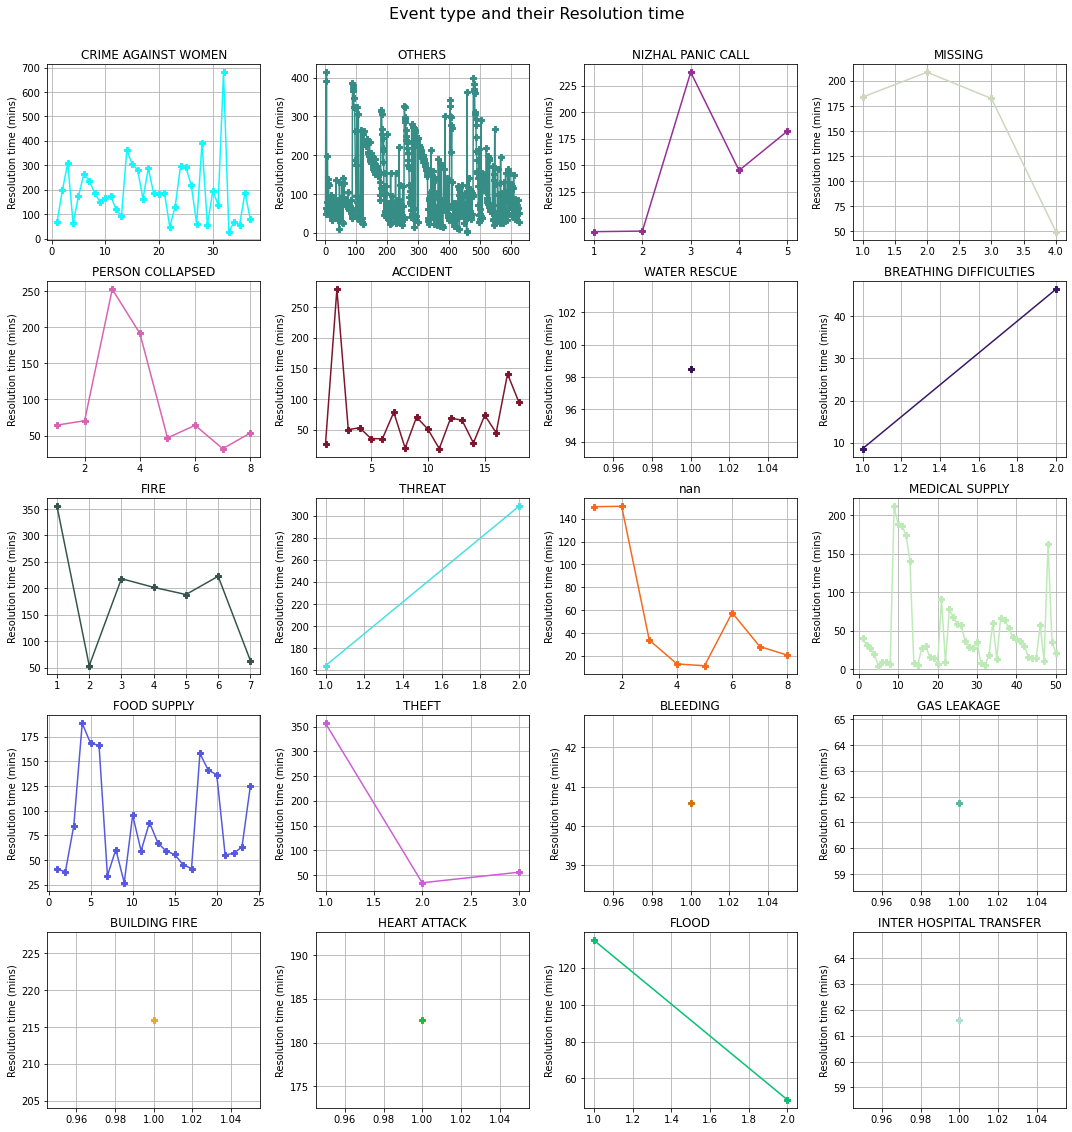

In [6]:
#Plotting Event type and their Resolution time
dic = {}
for i in combined:
  if(i[2] in dic.keys()):
    dic[i[2]].append(convert_time(i[1],i[11]))
  else:
    dic[i[2]] = [convert_time(i[1],i[11])]
fig = plt.figure(figsize=(15, 16))
fig.suptitle('Event type and their Resolution time',fontsize=16)
fig.subplots_adjust(hspace = .3, wspace=.001)
for key,it in zip(dic,range(1,21)):
  index = []
  for i in range(1,len(dic[key])+1):
    index.append(i)
  r,b,g = random.random(),random.random(),random.random()
  color = (r, g, b)
  ax = fig.add_subplot(5,4,it)
  ax.plot(index,dic[key], color=color,marker='P')
  ax.set_title(key)
  ax.set_ylabel('Resolution time (mins)')
  ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

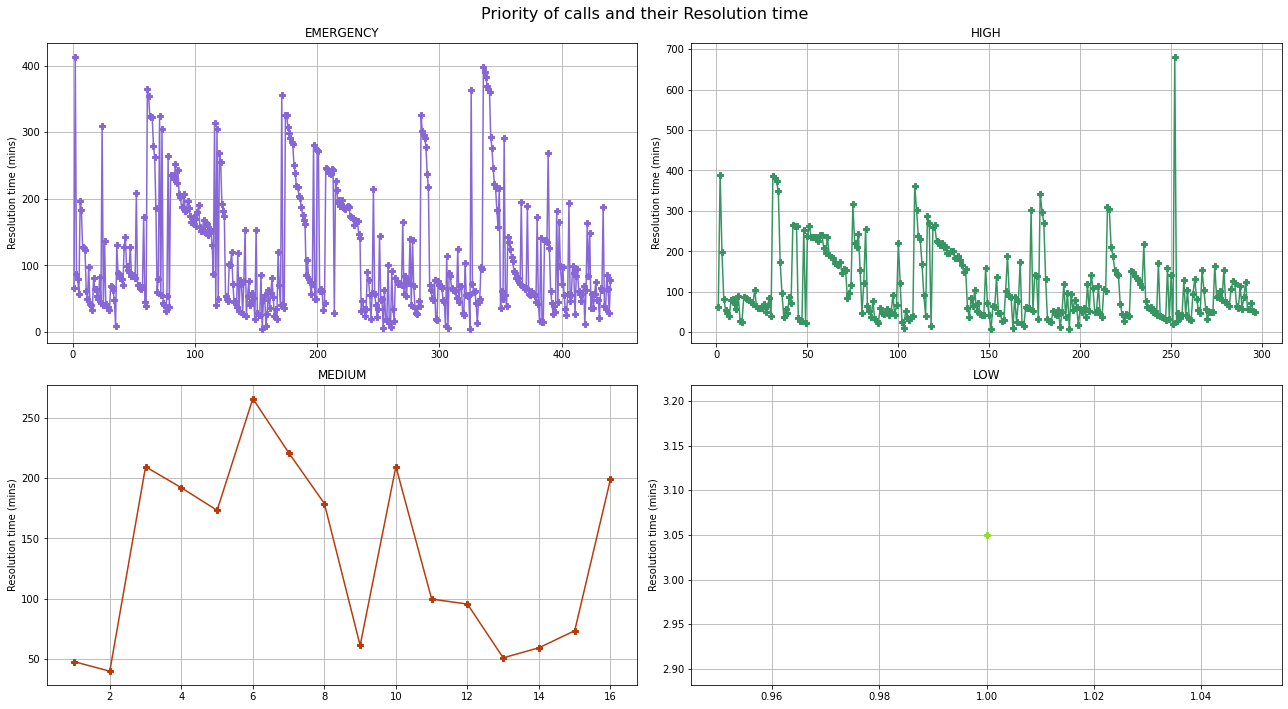

In [7]:
#Plotting Priority of calls and their Resolution time
dic = {}
for i in combined:
  if i[3]=='nan':
    continue
  if(i[3] in dic.keys()):
    dic[i[3]].append(convert_time(i[1],i[11]))
  else:
    dic[i[3]] = [convert_time(i[1],i[11])]

fig = plt.figure(figsize=(18, 10))
fig.suptitle('Priority of calls and their Resolution time',fontsize=16)
fig.subplots_adjust(hspace = .3, wspace=.001)
for key,it in zip(dic,range(1,5)):
  index = []
  for i in range(1,len(dic[key])+1):
    index.append(i)
  r,b,g = random.random(),random.random(),random.random()
  color = (r, g, b)
  ax = fig.add_subplot(2,2,it)
  ax.plot(index,dic[key], color=color,marker='P')
  ax.set_title(key)
  ax.set_ylabel('Resolution time (mins)')
  ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

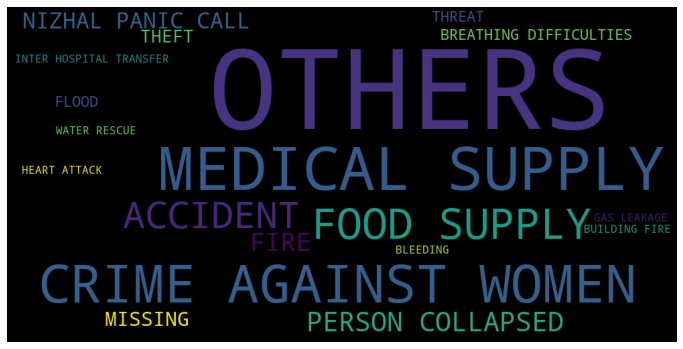

In [8]:
#WordCloud for Crimes Reported
ls = []
for i in combined:
  if i[2]=="nan":
    continue
  ls.append(i[2])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [9]:
#Using NLTK to find Top Keywords based on caller comments
string = ""
for i in combined:
  if(i[2]=="OTHERS"):
    string += str(i[15])
string = string.strip('\n')
stops = ["caller","informed","callers","PS",'ps','loc:','PS,','!','@','#','$','%','^','&','*','-','_',':',";",',','.','loc;','SAYS','IN','fish']
stop_words = set(stopwords.words('english'))
for i in stops:
  stop_words.add(i)
total_words = string.split()
total_word_length = len(total_words)
total_sentences = tokenize.sent_tokenize(string)
total_sent_len = len(total_sentences)
tf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in tf_score:
            tf_score[each_word] += 1
        else:
            tf_score[each_word] = 1

# Dividing by total_word_length for each dictionary element
tf_score.update((x, y/int(total_word_length)) for x, y in tf_score.items())

def check_sent(word, sentences): 
    final = [all([w in x for w in word]) for x in sentences] 
    sent_len = [sentences[i] for i in range(0, len(final)) if final[i]]
    return int(len(sent_len))

idf_score = {}
for each_word in total_words:
    each_word = each_word.replace('.','')
    if each_word not in stop_words:
        if each_word in idf_score:
            idf_score[each_word] = check_sent(each_word, total_sentences)
        else:
            idf_score[each_word] = 1

idf_score.update((x, math.log(int(total_sent_len)/y)) for x, y in idf_score.items())

tf_idf_score = {key: tf_score[key] * idf_score.get(key, 0) for key in tf_score.keys()}

def get_top_n(dict_elem, n):
    result = dict(sorted(dict_elem.items(), key = itemgetter(1), reverse = True)[:n]) 
    return result

keywords = get_top_n(tf_idf_score,5)
print("Top Keywords are:")
for key in keywords.keys():
  print(key)

Top Keywords are:
gathered
near
people
gathering
shop


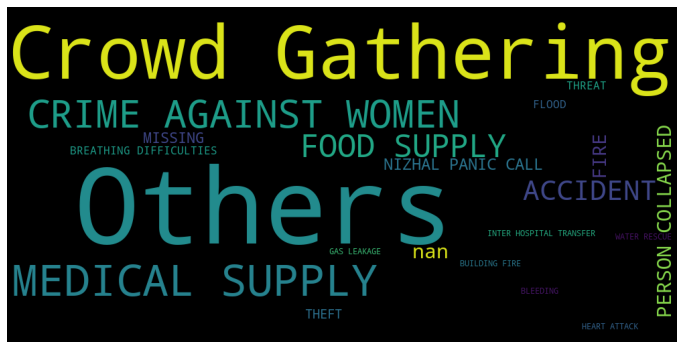

In [10]:
#New Word Cloud based on nltk results
ls = []
for i in combined:
  if(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        ls.append("Crowd Gathering")
    else:
        ls.append("Others")
  else:
    ls.append(i[2])
word_could_dict=Counter(ls)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:
#Event type and their Disconnect causes(i.e. NORMAL_DISCONNECTION, MISSED_CALL, REASON_UNKNOWN)
disconnect = {}
#Populate Disconnect dictionary
for i in combined:
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        disconnect["CROWD GATHERING"] = [0,0,0]
    else:
        disconnect["OTHERS"] = [0,0,0]
  else:
    disconnect[i[2]] = [0,0,0]

#Function to accumalte value in disconnect
def accumulate(ls,type):
  for j in ls:
    if(j=="NORMAL_DISCONNECTION"):
      disconnect[type][0] +=1
    elif(j=="MISSED_CALL"):
      disconnect[type][1] +=1
    else:
      disconnect[type][2] +=1

for i in combined:
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
      accumulate(i[17],"CROWD GATHERING")
    else:
      accumulate(i[17],"OTHERS")
  else:
    accumulate(i[17],i[2])

In [12]:
#Visualize the table
tab=[]
rowL=[]
colL = ["NORMAL DISCONNECTION","MISSED CALL","REASON UNKNOWN"]
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rowL)+1))
colors = colors[::-1]
for i in disconnect.keys():
  total = 0
  for k in disconnect[i]:
    total+= k
  lt = disconnect[i]
  lt = [f'{x/total*100:1.2f}' for x in lt]
  lt.insert(0,i)
  tab.append(lt)
  rowL.append(i)
from prettytable import PrettyTable
table = PrettyTable()
table.title = 'Event and their Call disconnections (%)'
table.field_names = ["Events \ Call types","NORMAL DISCONNECTION","MISSED CALL","REASON UNKNOWN"]
for i in tab:
  table.add_row(i)
print(table)

+-------------------------------------------------------------------------------+
|                    Event and their Call disconnections (%)                    |
+-------------------------+----------------------+-------------+----------------+
|   Events \ Call types   | NORMAL DISCONNECTION | MISSED CALL | REASON UNKNOWN |
+-------------------------+----------------------+-------------+----------------+
|   CRIME AGAINST WOMEN   |        52.82         |    20.00    |     27.18      |
|          OTHERS         |        62.98         |    16.03    |     20.99      |
|    NIZHAL PANIC CALL    |        75.00         |     0.00    |     25.00      |
|         MISSING         |        46.88         |    40.62    |     12.50      |
|     CROWD GATHERING     |        64.27         |    15.00    |     20.73      |
|     PERSON COLLAPSED    |        70.00         |    25.00    |      5.00      |
|         ACCIDENT        |        75.41         |    11.48    |     13.11      |
|       WATER RE

In [13]:
def check_slot(time):
  string1 = parse_time(time)
  format = "%Y-%m-%d %H:%M:%S"
  datetime_str1 = datetime.datetime.strptime(string1, format)
  tmp = str(datetime_str1)
  tmp = tmp.split(" ",1)[1]
  mins = sum(x * int(t) for x, t in zip([60, 1, 1/60], tmp.split(":")))
  if(mins<240):
    return "slot1"
  elif(240<=mins<480):
    return "slot2"
  elif(480<=mins<720):
    return "slot3"
  elif(720<=mins<960):
    return "slot4"
  elif(960<=mins<1200):
    return "slot5"
  else:
    return "slot6"

lis = []
for i in combined:
  tmp = []
  tmp.append(check_slot(i[1]))
  tmp.append(i[4])
  if(i[2]=="nan"):
    continue
  elif(i[2]=="OTHERS"):
    string = str(i[15])
    string = string.lower()
    if("gather" in string or "crowd" in string):
        tmp.append("Crowd Gathering")
    else:
        tmp.append("Others")
  else:
    tmp.append(i[2])
  lis.append(tmp)

In [14]:
#Using Logistic Regression for Classification
reg = pd.DataFrame(lis)
ord_enc = OrdinalEncoder()
reg["time"] = ord_enc.fit_transform(reg[[0]])
reg["district"] = ord_enc.fit_transform(reg[[1]])
reg["crime"] = ord_enc.fit_transform(reg[[2]])

x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values

xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)
 
classifier1 = LogisticRegression(random_state = 0,solver='lbfgs',max_iter=10000000)
classifier1.fit(xtrain, ytrain)
y_pred = classifier1.predict(xtest)

print ("Accuracy using lbfgs solver: ",accuracy_score(ytest, y_pred))

classifier2 = LogisticRegression(random_state = 0,solver='saga',max_iter=10000000)
classifier2.fit(xtrain, ytrain)
y_pred = classifier2.predict(xtest)

print ("Accuracy using saga solver: ",accuracy_score(ytest, y_pred))

Accuracy using lbfgs solver:  0.41708542713567837
Accuracy using saga solver:  0.41708542713567837


In [15]:
#Using SVM
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)
svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain, ytrain)
y_pred = svclassifier.predict(xtest)
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         8
         5.0       0.00      0.00      0.00        74
         6.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         7
        12.0       0.67      0.36      0.47        11
        13.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         1
        15.0       0.44      0.99      0.60        85
        16.0       0.00      0.00      0.00         3
        18.0       0.00      0.00      0.00         1
        19.0       0.00      0.00      0.00         1

    accuracy                           0.44       199
   macro avg       0.08      0.10      0.08       199
weighted avg       0.22      0.44      0.28       199



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
#Using Deep Learning for Classification
x = reg.iloc[:, [3, 4]].values 
y = reg.iloc[:, 5].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)
model = Sequential()
model.add(Dense(10, input_dim=xtrain.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtrain, ytrain, epochs=50, batch_size=16, verbose=2)
_, accuracy = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: %.2f using Deep Learning' % (accuracy*100))

Epoch 1/50
38/38 - 0s - loss: 18.5624 - accuracy: 0.0236
Epoch 2/50
38/38 - 0s - loss: 3.4309 - accuracy: 0.0118
Epoch 3/50
38/38 - 0s - loss: -1.0701e+01 - accuracy: 0.0000e+00
Epoch 4/50
38/38 - 0s - loss: -2.4886e+01 - accuracy: 0.0000e+00
Epoch 5/50
38/38 - 0s - loss: -4.0506e+01 - accuracy: 0.0000e+00
Epoch 6/50
38/38 - 0s - loss: -5.8545e+01 - accuracy: 0.0000e+00
Epoch 7/50
38/38 - 0s - loss: -7.9235e+01 - accuracy: 0.0000e+00
Epoch 8/50
38/38 - 0s - loss: -1.0202e+02 - accuracy: 0.0000e+00
Epoch 9/50
38/38 - 0s - loss: -1.2766e+02 - accuracy: 0.0000e+00
Epoch 10/50
38/38 - 0s - loss: -1.5581e+02 - accuracy: 0.0000e+00
Epoch 11/50
38/38 - 0s - loss: -1.8667e+02 - accuracy: 0.0000e+00
Epoch 12/50
38/38 - 0s - loss: -2.2035e+02 - accuracy: 0.0000e+00
Epoch 13/50
38/38 - 0s - loss: -2.5737e+02 - accuracy: 0.0000e+00
Epoch 14/50
38/38 - 0s - loss: -2.9828e+02 - accuracy: 0.0000e+00
Epoch 15/50
38/38 - 0s - loss: -3.4264e+02 - accuracy: 0.0000e+00
Epoch 16/50
38/38 - 0s - loss: -3.91

In [17]:
#Lets use Dummy Variables to encode and see if we can increase the Accuracy
df1 = pd.get_dummies(reg,columns=["time","district"])
df1.head()

,0,1,2,crime,time_0.0,time_1.0,time_2.0,district_0.0,district_1.0,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,district_12.0,district_13.0,district_14.0
0,slot1,Malappuram,CRIME AGAINST WOMEN,4.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,slot1,Thrissur,Others,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,slot1,Thrissur,Others,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,slot1,Thrissur,Others,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,slot1,Thiruvananthapuram,Others,15.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
#Using Dummy variables in Logistic Regression
x = df1.iloc[:,4:21].values 
y = df1.iloc[:, 3].values
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)
 
classifier1 = LogisticRegression(random_state = 0,solver='lbfgs',max_iter=10000000)
classifier1.fit(xtrain, ytrain)
y_pred = classifier1.predict(xtest)
print ("Accuracy using lbfgs solver: ",accuracy_score(ytest, y_pred))

classifier2 = LogisticRegression(random_state = 0,solver='saga',max_iter=10000000)
classifier2.fit(xtrain, ytrain)
y_pred = classifier2.predict(xtest)
print ("Accuracy using saga solver: ",accuracy_score(ytest, y_pred))

Accuracy using lbfgs solver:  0.48743718592964824
Accuracy using saga solver:  0.48743718592964824


In [19]:
#Using Dummy variables in SVM
xtrain, xtest, ytrain, ytest = train_test_split( x, y, test_size = 0.25, random_state = 0)

svclassifier = SVC(kernel='linear')
svclassifier.fit(xtrain, ytrain)
y_pred = svclassifier.predict(xtest)
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         8
         5.0       0.53      0.50      0.51        74
         6.0       0.00      0.00      0.00         2
         8.0       0.00      0.00      0.00         7
        12.0       1.00      0.36      0.53        11
        13.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         1
        15.0       0.49      0.72      0.58        85
        16.0       0.00      0.00      0.00         3
        18.0       0.00      0.00      0.00         1
        19.0       0.00      0.00      0.00         1

    accuracy                           0.51       199
   macro avg       0.16      0.12      0.13       199
weighted avg       0.46      0.51      0.47       199



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#Using Dummy Variables in Deep Learning
model = Sequential()
model.add(Dense(10, input_dim=xtrain.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtrain, ytrain, epochs=50, batch_size=16, verbose=2)
_, accuracy = model.evaluate(xtest, ytest, verbose=0)
print('Accuracy: %.2f using Deep Learning' % (accuracy*100))

Epoch 1/50
38/38 - 0s - loss: 2.7217 - accuracy: 0.0118
Epoch 2/50
38/38 - 0s - loss: 0.4093 - accuracy: 0.0101
Epoch 3/50
38/38 - 0s - loss: -2.2816e+00 - accuracy: 0.0101
Epoch 4/50
38/38 - 0s - loss: -5.7057e+00 - accuracy: 0.0000e+00
Epoch 5/50
38/38 - 0s - loss: -1.0255e+01 - accuracy: 0.0000e+00
Epoch 6/50
38/38 - 0s - loss: -1.5840e+01 - accuracy: 0.0000e+00
Epoch 7/50
38/38 - 0s - loss: -2.2623e+01 - accuracy: 0.0000e+00
Epoch 8/50
38/38 - 0s - loss: -3.0656e+01 - accuracy: 0.0000e+00
Epoch 9/50
38/38 - 0s - loss: -3.9824e+01 - accuracy: 0.0000e+00
Epoch 10/50
38/38 - 0s - loss: -5.0207e+01 - accuracy: 0.0000e+00
Epoch 11/50
38/38 - 0s - loss: -6.1671e+01 - accuracy: 0.0000e+00
Epoch 12/50
38/38 - 0s - loss: -7.4113e+01 - accuracy: 0.0000e+00
Epoch 13/50
38/38 - 0s - loss: -8.7522e+01 - accuracy: 0.0000e+00
Epoch 14/50
38/38 - 0s - loss: -1.0175e+02 - accuracy: 0.0000e+00
Epoch 15/50
38/38 - 0s - loss: -1.1706e+02 - accuracy: 0.0000e+00
Epoch 16/50
38/38 - 0s - loss: -1.3316e+0